In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
!pip install plotly

  Using cached https://files.pythonhosted.org/packages/79/92/f8282ed209c2e7d4077c5f236bc241d42fb9a2b2986330188909a60be7bb/plotly-5.8.0-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/f2/a5/f86bc8d67c979020438c8559cc70cfe3a1643fd160d35e09c9cca6a09189/tenacity-8.0.1-py3-none-any.whl


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os, sys
import datetime
import seaborn as sns
import scipy.stats as stats
from scipy.stats import chi2_contingency, beta, binom
from statsmodels.stats.proportion import proportions_ztest
from matplotlib.lines import Line2D
import plotly.graph_objs as go

In [5]:
sys.path.append(os.path.abspath(os.path.join('../scripts')))
from plot import Plot

In [6]:
import warnings
warnings.filterwarnings('ignore')

In [7]:
dff = pd.read_csv('../data/AdSmartABdata.csv')

## Classical approach of AB Testing
Question: Does the Smart add (experiment = 1) show an improvement in user engagement (response rate)

Null Hypothesis:
                H0: there is no difference in brand awareness between the exposed and control groups


Alt Hypothesis:  H1: there is a difference in brand awareness between the exposed and control groups


Method: Binomial test

Threshold or significance level: 0.05

In [8]:
# Filter out users that were not interacting
relevant_rows = dff.query('yes == 1 | no == 1')

# Divide a dataframe by exposed and control group
exposed = relevant_rows.query('experiment == "exposed"')
control = relevant_rows.query('experiment == "control"')

# Calculate a number of observation in both groups
print('The exposed group dataframe has {} observations'. format(exposed.shape[0]))
print('The control group dataframe has {} observations'. format(control.shape[0]))

exposed_mean = '{0:.2f}%'.format(exposed.yes.mean()*100)
control_mean = '{0:.2f}%'.format(control.yes.mean()*100)
print('The conversion rate in the exposed group is equal to {}'.format(exposed_mean))
print('The conversion rate in the exposed group is equal to {}'.format(control_mean))

The exposed group dataframe has 657 observations
The control group dataframe has 586 observations
The conversion rate in the exposed group is equal to 46.88%
The conversion rate in the exposed group is equal to 45.05%


In [9]:
obs_diff = exposed.yes.mean() - control.yes.mean()
obs_diff_form = '{0:.2f}%'.format(obs_diff*100)
print('The observed difference in the conversion rate between the exposed and the control group is {}'.format(obs_diff_form))

The observed difference in the conversion rate between the exposed and the control group is 1.83%


In [10]:
exposed_converted = exposed.query('yes == 1')
control_converted = control.query('yes == 1')
print('The sample sizes of the exposed group and control group are {} and {} respectively'.format(exposed.shape[0], control.shape[0]))
print('The number of conversions in the exposed group and control group is {} and {} respectively'.format(exposed_converted.shape[0],
                                                                                          control_converted.shape[0]))

The sample sizes of the exposed group and control group are 657 and 586 respectively
The number of conversions in the exposed group and control group is 308 and 264 respectively


In [11]:
#storing number of conversions for exposed and control groups as numpy arrays
count = np.array([exposed_converted.shape[0], control_converted.shape[0]])
#storing sample sizes of exposed and control group as numpy arrays
nobs = np.array([exposed.shape[0], control.shape[0]])
#storing results of z test in variables
stat, p_val = proportions_ztest(count, nobs, alternative = 'larger')
p_form = '{0:.2f}%'.format(p_val*100)
print('P-value is equal to {}'.format(p_form))

P-value is equal to 25.92%


In [12]:
# Draw 100000 samples from binominal distribution
exposed_simulation = np.random.binomial(exposed.shape[0], exposed.yes.mean(), 100000)/exposed.shape[0]
control_simulation = np.random.binomial(control.shape[0], control.yes.mean(), 100000)/control.shape[0]
p_diffs = exposed_simulation - control_simulation
diffs = np.array(p_diffs)

#Creation of normal distribution centered at zero
null_vals = np.random.normal(0, np.std(diffs), len(diffs))

In [13]:
def statplot(data, lim, obs_stat, title):
    """
    This function creates a plot, that represents sampling distribution. 
    This plot is formatted and has main statistics on it
    Arguments:
    data = array
    lim = height of the plot
    obs_stat = observed statistic
    title = chart title
    """
    
    #Create a kdeplot
    plt.figure(figsize=(12,4), tight_layout=True)
    ax = sns.kdeplot(data, linewidth = 0.8, color = 'black')
    
    # Simple formatting
    frame = ['right', 'left', 'top']
    for i in frame:
        ax.spines[i].set_visible(False)

    plt.title(title)
    plt.ylabel('')
    plt.yticks([], [])
    
    # Legend
    line = Line2D([0], [0], color='red', linestyle = '-', label='observed statistic')
    line_dashed = Line2D([0], [0], color='black', linestyle = '--', label='mean and standard deviation')
    plt.legend(handles=[line, line_dashed], loc='upper left');
    
    # Create a list of 3 standard deviation to the left and to the right and mean
    std_list = []
    std_list_format = []
    for i in range(-3,4):
        std_dev = np.std(data) * i + np.mean(data)
        std_list.append(std_dev)
        std_list_format.append('{0:.3f}'.format(std_dev) + '\n {} std'.format(i))
        
        # Create a list of corresponding y values
    data_x, data_y = ax.lines[0].get_data()
    height = []
    for i in std_list:
        height.append(np.interp(i, data_x, data_y))
        
    # Plotting vertical lines representing std deviations 
    for a, b in zip(std_list, height):
        plt.axvline(a, 0, b/lim, color = 'black', alpha = 1, linewidth = 0.8, linestyle = '--')
        plt.plot(a, b, marker = 'o', color = 'blue')
    
    # Plotting observed statistic
    obs_line_height = np.interp(obs_stat, data_x, data_y)
    plt.axvline(obs_stat, 0, obs_line_height/lim, color = 'red', alpha = 1, linewidth = 0.8, linestyle = '-')
    plt.plot(obs_stat, obs_line_height, marker = 'o', color = 'red')
            
    # Plotting x ticks
    x_ticks = std_list
    x_labels = std_list_format
    plt.xticks(x_ticks, x_labels)
    plt.ylim(0,lim)

In [14]:
def shading(data, left, right, color):
    
    """
    This function shades areas of the kde plot.
    Arguments:
    data = array
    left = left boundary of the area to be shaded
    right = right boundary of the area to be shaded
    color = color
    """
    
    #Shading areas
    kde = stats.gaussian_kde(data)
    shade = np.linspace(left, right, 100)
    plt.fill_between(shade, kde(shade), color = color, alpha = 0.5);

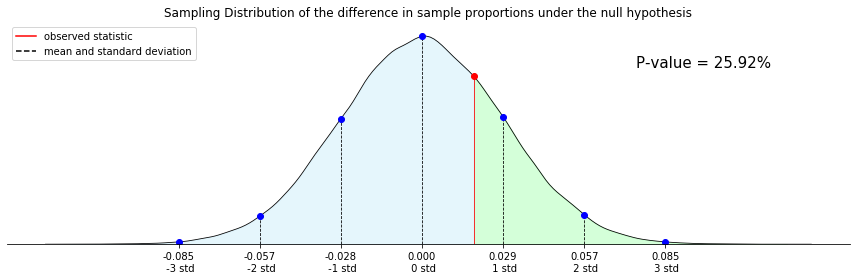

In [15]:
# Plotting the sampling distribution
statplot(null_vals, 15, obs_diff, 'Sampling Distribution of the difference in sample proportions under the null hypothesis')
shading(null_vals, obs_diff, null_vals.max(),'#aaffb5')
shading(null_vals, null_vals.min(), obs_diff,'#cceefb')
plt.text(0.075, 12, "P-value = {}".format(p_form), color = 'black', size = 15);

The probability that the observed difference falls into the sampling distribution of the null hypothesis is equal to 25.92% (0.25). Given that our level of significance is 5% (0.05), we fail to reject the null hypothesis, ie we do not have enough evidence to conclude that the conversion rate with the new creative ad is higher than with the dummy one.

In [16]:
# Calculate z statistic
zscore = stats.norm.ppf(1 - .05)

# Calculate mean proportion for exposed group
p1 = exposed.yes.mean()
# Calculate mean proportion for control group
p2 = control.yes.mean()
# Calculate distance from the mean
distance_from_mean = ((p1*(1-p1)/exposed.yes.shape[0]) + (p2*(1-p2)/control.yes.shape[0])) ** 0.5 * zscore

# Lower boarder of the interval
low = obs_diff - distance_from_mean
# Higher boarder of the interval
high = obs_diff + distance_from_mean

print('The 90% confidence interval falls between {} and {}.'.format(low, high))

The 90% confidence interval falls between -0.02828080835958243 and 0.06485204695055077.


In [17]:
# Experiment 1:

control_conversion = dff[(dff['experiment'] == 'control') & (dff['yes'] == 1)].shape[0] / dff[(dff['experiment'] == 'control')].shape[0]
treatment_conversion = dff[(dff['experiment'] == 'exposed') & (dff['yes'] == 1)].shape[0] / dff[(dff['experiment'] == 'exposed')].shape[0]
lift = (treatment_conversion - control_conversion) / control_conversion


print(f"control conversion percentage: {round(control_conversion * 100, 2)}%")
print(f"Treatment conversion percentage: {round(treatment_conversion * 100, 2)}%")
print(f"Lift percentage: {round(lift * 100, 2)}%")

control conversion percentage: 6.48%
Treatment conversion percentage: 7.69%
Lift percentage: 18.56%


In [18]:
# Create Contngency Table for chi square test
control_converted = dff[(dff['experiment'] == 'control') & (dff['yes'] == 1)].shape[0]
treatment_converted = dff[(dff['experiment'] == 'exposed') & (dff['yes'] == 1)].shape[0]
control_non_converted = dff[(dff['experiment'] == 'control') & (dff['no'] == 1)].shape[0]
treatment_not_converted = dff[(dff['experiment'] == 'exposed') & (dff['no'] == 1)].shape[0]

contingency_table = np.array([[control_converted, control_non_converted], [treatment_converted,         treatment_not_converted]])

In [19]:
contingency_table

array([[264, 322],
       [308, 349]])

In [20]:
chi, p_value, _, _ = chi2_contingency(contingency_table, correction=False)

In [21]:
chi, p_value

(0.41690289642162887, 0.518486498219898)